In [86]:
import math
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import gymnasium as gym
import gym_bondgraph
from bond_graph import *
import numpy as np
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%reload_ext autoreload
%autoreload 2

### Set up seed bond graph

In [87]:
t_span = [0, 3.0]
t = np.linspace(t_span[0], t_span[1], 1000)

env = gym.make('gym_bondgraph/QuarterCarSuspEnv',  seed=1, t=t)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
env.reset()

(array([ 1861., 19660.]), {'z': []})

In [89]:
action = spaces.Discrete(4, start=0)
action.sample()
print(action)

# observation, reward, terminated, False, info
env.step(action)


Discrete(4)


(array([ 1861., 19660.]), 1.3561575515548752, False, False, {'z': []})

In [90]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

## Q-Network

In [91]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, n_actions)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)



In [92]:

n_actions = env.action_space.n
n_observations = env.observation_space.shape
state, info = env.reset()
n_observations = len(state)

test_net = DQN(n_actions, n_observations)

print(env.observation_space)

print("Number of Observations: ", n_observations)
print("Number of Actions: ", n_actions)
# n_observations = env.flattened_observation_space.shape[0]
# observation = env.reset()

# observation = torch.tensor([observation], dtype=torch.float32)

Box([5.e+02 2.e-05], [4.5e+03 2.0e-04], (2,), float64)
Number of Observations:  2
Number of Actions:  4


## Training

In [93]:

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # Epsilon-greedy sampling
    if sample > eps_threshold: # Choose action greedily
        with torch.no_grad():

            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # print("policy_net(state):", policy_net(state))
            integer_action = policy_net(state).max(1).indices.view(1, 1).item()
            # print("scalar_action:", scalar_action)
            
            # add_node_space = spaces.Discrete(env.num_node_types-3, start=3, seed=scalar_action) # node additions correspond to choosing what type you want, don't include the NONE type for adding
            # add_edge_space = spaces.MultiDiscrete([env.max_nodes, env.max_nodes, 2], seed=scalar_action) # edge additions sample space
            # MAX_PARAM_VAL = 10
            # action_space = spaces.Dict(
            #     {
            #         'node_or_bond': spaces.Discrete(2, start=0, seed=scalar_action),
            #         'node_param': spaces.Discrete(MAX_PARAM_VAL, start=1, seed=scalar_action),
            #         "node_type": add_node_space,
            #         "bond": add_edge_space,
            #     }
            # )
            # action = action_space.sample()

            return policy_net(state).max(1).indices.view(1, 1)
            # return action

    else: # Random sampling
        action = env.action_space.sample()
        action = np.random.randint(0, n_actions)

        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.int64)

episode_durations = []
best_episode_rewards = []
cumulative_rewards = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
            
def plot_best_episode_rewards(show_result=False):
    plt.figure(2)
    rewards_t = torch.tensor(best_episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())



    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
            
def plot_durations_and_rewards(show_result=False):
    plt.figure(figsize=(15,5))

    # Plot durations
    plt.subplot(1, 3, 1)  # 1 row, 2 columns, first plot
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result - Duration')
    else:
        plt.title('Training - Duration')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    else:
        means = durations_t.unfold(0, len(durations_t), 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(len(durations_t)-1), means))

    # Plot best episode rewards
    plt.subplot(1, 3, 2)  # 1 row, 2 columns, second plot
    rewards_t = torch.tensor(best_episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result - Reward')
    else:
        plt.title('Training - Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    else:
        means = rewards_t.unfold(0, len(rewards_t), 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(len(rewards_t)-1), means))
        
    # Plot cumulative episode rewards
    plt.subplot(1, 3, 3)  # 1 row, 2 columns, second plot
    rewards_t = torch.tensor(cumulative_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result - Cumulative Reward')
    else:
        plt.title('Training - Cumulative Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.tight_layout()
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Training Loop

In [94]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    # state_batch = torch.cat([torch.from_numpy(s) for s in batch.state])
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # print("action_batch: ", action_batch)
    # print("state batch: ", state_batch)
    # print("policy_net(state_batch): ", policy_net(state_batch))
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # state_action_values = policy_net(state_batch).gather(1, action_batch.long())

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


<Figure size 640x480 with 0 Axes>

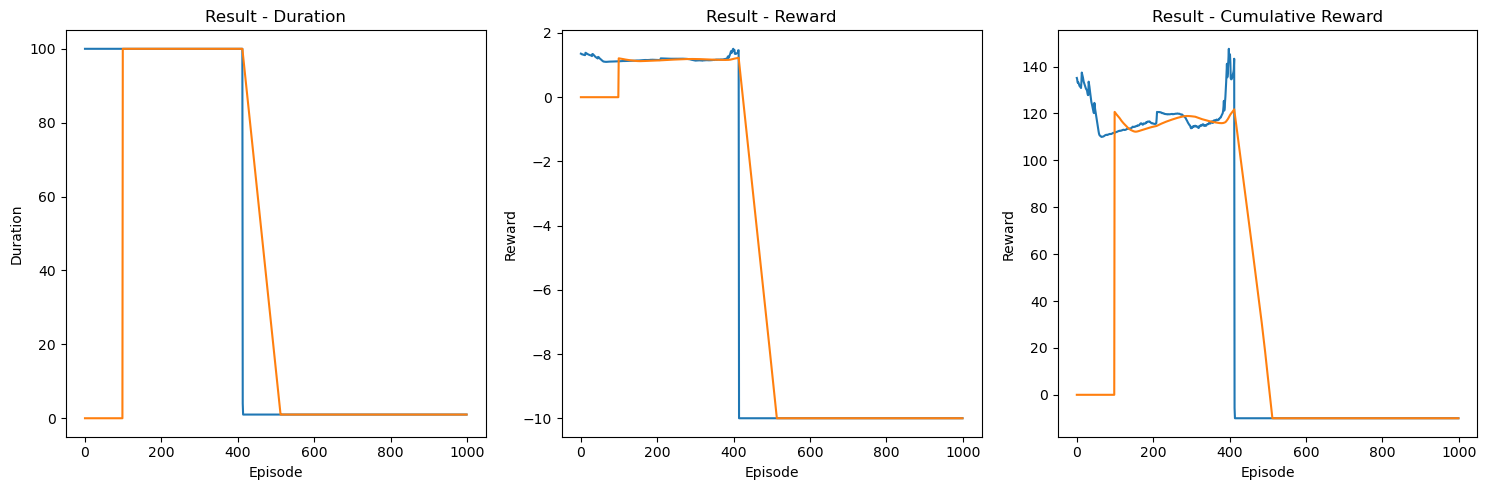

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [95]:
best_reward = 0.0
best_response = None
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()

    ## Initialize best reward per episode
    best_episode_rewards.append(-sys.float_info.max)
    cumulative_rewards.append(0.0)
    
    
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        ## Epsilon greedy selection of next action
        # integer_action = select_action(state)
        action = select_action(state)
        
        
        # print("Flattened Observation: ", state)
        # print("Selected Integer Action: ", integer_action)
        # print("Selected Composite Action: ", composite_action)
        # print()

        observation, reward, terminated, truncated, info = env.step(action.item())
        
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        observation = spaces.utils.flatten(env.observation_space, observation)

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        ## Store the best reward per episode
        if reward > best_episode_rewards[i_episode]:
            best_episode_rewards[i_episode] = reward
        
        if reward > best_reward:
            best_reward = reward
            best_response = info["z"]

        cumulative_rewards[i_episode] += reward
        
        ## Store the transition in memory
        memory.push(state, action, next_state, reward)

        ## Move to the next state
        state = next_state

        ## Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            # plot_best_episode_rewards()
            plot_durations_and_rewards()
            break

print('Complete')
# plot_durations(show_result=True)
plot_durations_and_rewards(show_result=True)
plt.ioff()
plt.show()

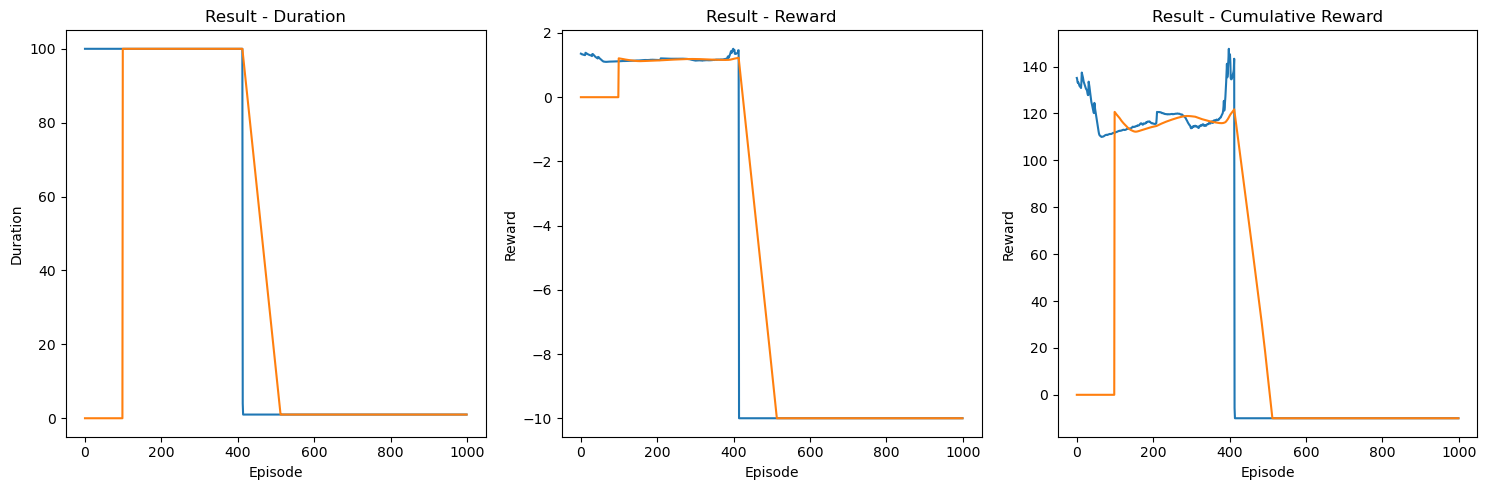

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [96]:
# cumulative_rewards
plot_durations_and_rewards(show_result=True)
plt.ioff()
plt.show()

In [97]:
100/max(best_episode_rewards)

tensor([66.3504], device='cuda:0', dtype=torch.float64)